# Exercise : 2

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

In [3]:
# load and prepare dataset
from sklearn.datasets import fetch_openml
MNIST = fetch_openml("mnist_784", as_frame=False)

In [4]:
MNIST.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = MNIST.data, MNIST.target

In [6]:
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
# Splitting training and test set
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

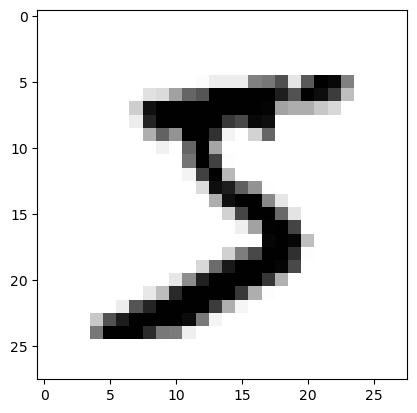

In [8]:
# plotting some image

import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape(28,28), cmap="binary")
plt.show()

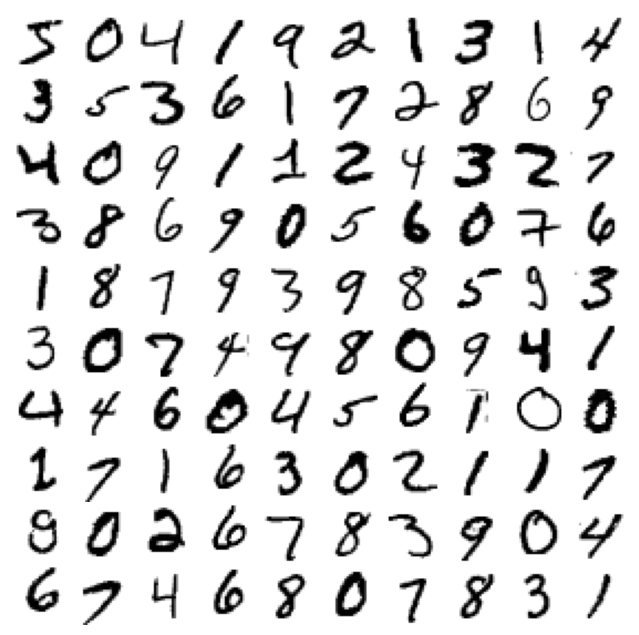

In [9]:
# plotting first 100 images

plt.figure(figsize=(8,8))

for idx, image in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx+1)
    plt.imshow(image.reshape(28,28), cmap="binary")
    plt.axis("off")
    
   
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

First we would get the best hyperparameter for the model using `Grid_Search`. After getting the best hypermeter we will train the model on `Augmented Data`  

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6]}] 

grid_search = GridSearchCV(estimator=knn_clf,
                           param_grid=param_grid,
                           cv=3)

grid_search.fit(X_train[:10000], y_train[:10000])

/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [11]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

## Shifting Image Illustration

Defining an image shifting function:

In [12]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    """Image shifting function.
    image: 1-dim array, size = 784
    dx: int
    dy: int
    """
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx])
    return shifted_image.reshape([-1])

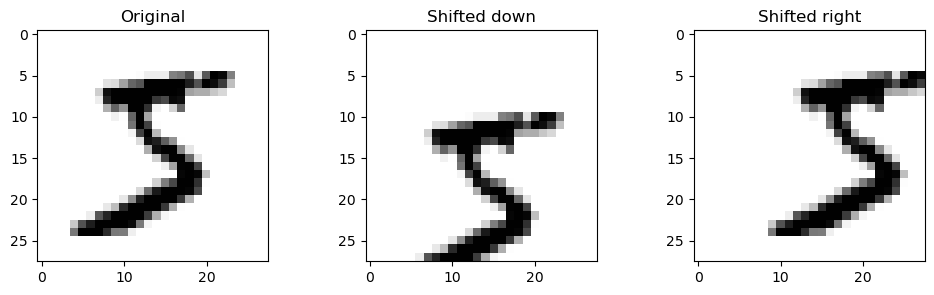

In [13]:
# Example illustration of shifting an image

some_image = X[0]
shifted_image_down = shift_image(some_image, 0, 5)
shifted_image_right = shift_image(some_image, 5, 0)

plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.title("Original")
plt.imshow(some_image.reshape(28, 28), cmap="binary")

plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28), cmap="binary")

plt.subplot(133)
plt.title("Shifted right")
plt.imshow(shifted_image_right.reshape(28, 28), cmap="binary")

plt.show()

## Augmenting Data

In [14]:
import numpy as np

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

Let's shuffle the augmented training set:

In [15]:
shuffle_idx = np.random.permutation(len(X_train_augmented))

X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Let's train the model using the best hyperparameters we found earlier:

In [16]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [17]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [18]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763